In [1]:
import networkx as nx

import matplotlib.pyplot as plt
import random
import json
import community as community_louvain

import numpy as np

import numpy as np
from scipy.sparse import csr_matrix

# 设置随机种子
random.seed(42)
np.random.seed(42)
from networkx.algorithms.community import girvan_newman

In [2]:
import infomap

In [3]:
def read_directed_graph(file_path, skip_lines):
    G = nx.DiGraph()  # Initialize an empty directed graph
    with open(file_path, 'r') as file:
        for _ in range(skip_lines):
            next(file)  # Skip the initial descriptive lines
        for line in file:
            parts = line.strip().split()
            if len(parts) == 2:  # Only consider lines with exactly two node identifiers
                u, v = parts
                G.add_edge(u, v)
    
    return G

path = '/Users/qing/Desktop/24s1/comp8880/project/code/data/soc/soc-Epinions1.txt'
G = read_directed_graph(path,3)


In [4]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

num_nodes, num_edges

(75879, 508837)

In [5]:
with open('saved/network_metrics_epin.json', 'r') as f:
    loaded_data = json.load(f)

# 访问加载的数据
sorted_centrality = loaded_data["Centrality"]
sorted_pagerank =  loaded_data["PageRank"]
sorted_leaderRank =  loaded_data["LeaderRank"]
sorted_hIndex =  loaded_data["HIndex"]
sorted_kShell=  loaded_data["KShell"]
# 更多的访问可以根据需要添加


In [6]:

print(sorted_centrality[:3])
print(sorted_pagerank[:3])

print(sorted_hIndex[:3])
print(sorted_kShell[:3])


[['18', 0.04057829673950289], ['645', 0.029112522733862254], ['634', 0.026344922111811067]]
[['18', 0.004657194750781481], ['737', 0.002880680293522851], ['1719', 0.002154560973565739]]
[['645', 300], ['634', 264], ['44', 245]]
[['0', 91], ['4', 91], ['5', 91]]


In [70]:
print(sorted_leaderRank[-3:-1])

[['75885', 2.8653960184056075e-06], ['75886', 2.8653960184056075e-06]]


In [7]:
def community_aware_ranking(partition, node_centrality, budget=10):
    # Organize nodes by community and sort them within each community based on their centrality
    community_nodes = {}
    for node, comm in partition.items():
        if comm not in community_nodes:
            community_nodes[comm] = []
        community_nodes[comm].append(node)

    for comm in community_nodes:
        community_nodes[comm].sort(key=lambda x: node_centrality[x], reverse=True)

    # Select nodes from communities ensuring distribution across communities
    ranked_nodes = []
    
    while budget > 0 and any(community_nodes.values()):
        for comm in sorted(community_nodes, key=lambda x: len(community_nodes[x]), reverse=True):
            if community_nodes[comm]:
                ranked_nodes.append(community_nodes[comm].pop(0))
                budget -= 1
                if budget == 0:
                    break
    
    return ranked_nodes

In [10]:
degree_centrality = nx.degree_centrality(G)

In [8]:
# 示例：检测社区并统计前top节点的分布
G_edge = nx.read_edgelist('/Users/qing/Desktop/24s1/comp8880/project/code/data/soc/soc-Epinions1.txt')  # 加载您的网络数据
partition = partition = community_louvain.best_partition(G_edge)



In [11]:

budget = 100

ranked_nodes_Baseline = community_aware_ranking(partition, degree_centrality, budget)

print("Ranked Nodes:", ranked_nodes_Baseline)


Ranked Nodes: ['790', '645', '18', '737', '1501', '763', '644', '1749', '71399', '7047', '45437', '1533', '7040', '4716', '390', '2565', '3415', '12023', '6774', '4920', '3345', '9057', '7488', '3864', '1189', '1830', '4620', '1641', '18693', '3137', '1017', '5887', '11967', '2425', '23920', '4616', '11780', '44812', '16729', '50463', '24555', '3426', '1310', '75769', '45052', '21718', '39303', '72346', '4944', '47937', '43043', '26098', '28804', '22345', '12413', '8554', '24321', '9077', '11610', '2192', '12751', '19107', '48580', '6835', '50140', '33757', '14703', '47751', '15764', '7841', '29176', '43452', '37456', '6264', '47018', '43527', '33367', '72446', '58810', '23270', '52133', '25229', '36941', '2321', '16316', '19169', '26408', '22307', '39387', '51130', '35011', '45237', '9010', '20616', '1419', '17044', '26677', '23392', '34342', '22905']


In [12]:


import numpy as np

def community_aware_ranking_ours_past(partition, leader_rank_scores, budget=10, alpha=2):
    # Organize nodes by community
    community_nodes = {}
    community_sizes = {}
    for node, comm in partition.items():
        if comm not in community_nodes:
            community_nodes[comm] = []
            community_sizes[comm] = 0
        community_nodes[comm].append(node)
        community_sizes[comm] += 1

    # Calculate community weights based on size and LeaderRank scores
    community_weights = {}
    for comm, nodes in community_nodes.items():
        leader_rank_sum = sum(leader_rank_scores[node] for node in nodes)
        community_weights[comm] = (community_sizes[comm] * leader_rank_sum) ** alpha
    
    # Normalize weights to distribute budget
    total_weight = sum(community_weights.values())
    community_budgets = {comm: int(budget * (weight / total_weight)) for comm, weight in community_weights.items()}
    
    # Adjust budget rounding issues
    allocated_budget = sum(community_budgets.values())
    while allocated_budget < budget:
        for comm in community_budgets:
            community_budgets[comm] += 1
            allocated_budget += 1
            if allocated_budget == budget:
                break

    # Select nodes from communities based on assigned budgets
    ranked_nodes = []
    for comm in community_nodes:
        community_nodes[comm].sort(key=lambda x: leader_rank_scores[x], reverse=True)
        ranked_nodes.extend(community_nodes[comm][:community_budgets[comm]])

    return ranked_nodes



def community_aware_ranking_ours_v4(partition, leader_rank_scores, community_kshell, budget=10, alpha=1.5):
    # Organize nodes by community and sort them within each community based on their centrality
    community_nodes = {}
    for node, comm in partition.items():
        if comm not in community_nodes:
            community_nodes[comm] = []
        community_nodes[comm].append(node)

    for comm in community_nodes:
        community_nodes[comm].sort(key=lambda x: leader_rank_scores[x], reverse=True)

    # Calculate total k-shell values for each community to determine budget distribution
    community_kshell_sums = {}
    for node, comm in partition.items():
        if comm not in community_kshell_sums:
            community_kshell_sums[comm] = 0
        community_kshell_sums[comm] += community_kshell[node]

    # Calculate total k-shell values across all communities to normalize the distribution
    total_kshell_sum = sum(community_kshell_sums.values())

    # Determine budget for each community based on their k-shell sum raised to the power alpha
    community_budgets = {comm: int(((community_kshell_sums[comm] / total_kshell_sum) ** alpha) * budget) for comm in community_nodes}

    # Adjust budgets due to integer rounding, distribute any remaining budget
    allocated_budget = sum(community_budgets.values())
    while allocated_budget < budget:
        for comm in sorted(community_budgets, key=lambda x: community_kshell_sums[x], reverse=True):
            community_budgets[comm] += 1
            allocated_budget += 1
            if allocated_budget == budget:
                break

    # Select nodes from communities based on assigned budgets
    ranked_nodes = []
    for comm in sorted(community_nodes, key=lambda x: community_kshell_sums[x], reverse=True):
        ranked_nodes.extend(community_nodes[comm][:community_budgets[comm]])

    return ranked_nodes


In [173]:
import networkx as nx
import numpy as np
import community as community_louvain

def community_aware_ranking_ours_v5(G, partition, degree_centrality, k_shell_scores, total_budget, distance_threshold):
    """
    对社交网络进行资源分配和节点选择，结合社区划分、节点度中心性、k-shell得分和距离阈值。
    使用线性归一化来代替Softmax进行预算分配。

    参数:
    G: NetworkX图对象，表示社交网络。
    partition: 字典，节点到社区ID的映射。
    degree_centrality: 字典，节点的度中心性得分。
    k_shell_scores: 字典，节点的k-shell得分。
    total_budget: 整个网络的总预算，表示可以选择的节点总数。
    alpha: k-shell得分的权重。
    beta: 社区大小得分的权重。
    distance_threshold: 最短路径距离阈值，用于确定节点间的紧密程度。

    返回:
    selected_nodes: 被选择的节点集合。
    """

    communities = {}
    for node, comm_id in partition.items():
        if comm_id not in communities:
            communities[comm_id] = []
        communities[comm_id].append(node)

    community_scores = {}
    for comm_id, nodes in communities.items():
        core_score = np.mean([k_shell_scores[node] for node in nodes])  # 计算该社区的平均k-shell得分
        size_score = len(nodes)  # 获取社区的大小
        community_scores[comm_id] = size_score * (core_score)
    #print("Community Scores:", community_scores)

    # 使用线性归一化来分配预算
    total_score = sum(community_scores.values())
    community_budgets = {comm: int((score / total_score) * total_budget) for comm, score in community_scores.items()}

   # print(community_budgets)
    # 选择节点，考虑节点间的距离阈值
    selected_nodes = set()
    for comm_id in communities:
        community_nodes = communities[comm_id]
        budget = community_budgets[comm_id]
        selected_for_comm = []

        # 按度中心性排序
        nodes_sorted = sorted(community_nodes, key=lambda n: degree_centrality[n], reverse=True)

        for node in nodes_sorted:
            if len(selected_for_comm) < budget:
                # 检查距离阈值
                too_close = any(nx.has_path(G, node, selected_node) and nx.shortest_path_length(G, node, selected_node) <= distance_threshold for selected_node in selected_for_comm)
                if not too_close:
                    selected_for_comm.append(node)
                    selected_nodes.add(node)
                    
    return selected_nodes

# 注意：使用该函数前需要提供有效的G, partition, degree_centrality, k_shell_scores等数据。


In [204]:
# 创建节点映射，将节点字符串映射为整数，同时创建反向映射
node_map = {node: i for i, node in enumerate(G_edge.nodes())}
reverse_node_map = {i: node for node, i in node_map.items()}  # 反向映射

# 初始化 Infomap
im = infomap.Infomap()

# 将网络数据添加到 Infomap 对象，确保节点ID是整数
for edge in G_edge.edges():
    source, target = edge
    im.add_link(node_map[source], node_map[target])

# 运行 Infomap 算法
im.run()


  Infomap v2.7.1 starts at 2024-05-18 15:17:21
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 75879 nodes and 405740 links...
  -> One-level codelength: 13.7319221

Trial 1/1 starting at 2024-05-18 15:17:22
Two-level compression: 13% 0.46% 0.00199360848% 0.0094821175% 
Partitioned to codelength 3.51294866 + 8.43828804 = 11.95123671 in 5042 modules.
Super-level compression: 0.000261939255% to codelength 11.9512054 in 5 top modules.

Recursive sub-structure compression: 12.8693358% 0.0146749913% 3.41049521e-05% 0% 

In [205]:

# 提取社区分区结果，直接使用反向映射
partition_infomap = {}
for node in im.tree:
    if node.is_leaf:
        original_node = reverse_node_map[node.node_id]  # 直接使用反向映射查找原始节点标识符
        partition_infomap[original_node] = node.module_id

In [16]:
leaderRank = leader_rank(G)

In [93]:
sorted_leaderRank =  sorted(leaderRank.items(), key=lambda item: item[1], reverse=True)

In [93]:
centrality_numpy = nx.eigenvector_centrality_numpy(G)

In [17]:
kShell = nx.core_number(G)

In [18]:
indegree_centrality = nx.in_degree_centrality(G)

In [190]:
hIndex = calculate_h_index(G)

In [24]:

total_budget = 100

#ranked_nodes_ours_infomap = community_aware_ranking_ours_v4(partition, leaderRank,kShell, budget)

ranked_nodes_ours = community_aware_ranking_ours_v4(partition, leaderRank,kShell, total_budget)


print("Ranked Nodes:", ranked_nodes_ours)


Ranked Nodes: ['401', '725', '27', '550', '34', '135', '1247', '31', '30', '1', '546', '74', '19', '433', '18', '40', '118', '136', '143', '77', '1191', '1164', '726', '1619', '1719', '790', '1909', '1621', '1753', '64', '4415', '1399', '299', '2113', '1895', '6509', '737', '849', '1401', '644', '763', '8370', '781', '873', '1749', '7040', '7047', '11501', '1533', '7693', '390', '3864', '3969', '10643', '3415', '6774', '3345', '1189', '4620', '1227', '1830', '3137', '2425', '35529', '1017', '4734', '1641', '5519', '12066', '4616', '4944', '44812', '1310', '11780', '16729', '2192', '27652', '24555', '75631', '12698', '39303', '47937', '10152', '3250', '59152', '43043', '32362', '25157', '25979', '9319', '28804', '40916', '21718', '12413', '37456', '45052', '26817', '3426', '22345', '10388']


In [206]:
ranked_nodes_v5 = community_aware_ranking_ours_v5(G_edge, partition_infomap, indegree_centrality, hIndex, total_budget, distance_threshold=0)


In [207]:
print("Ranked Nodes:", ranked_nodes_v5)


Ranked Nodes: {'438', '449', '128', '40', '1619', '2512', '395', '1749', '401', '388', '30', '385', '19', '854', '18', '1753', '2066', '918', '1719', '2239', '4415', '1401', '118', '59', '1172', '849', '74', '780', '44', '563', '3281', '681', '725', '443', '645', '4282', '418', '31', '12', '737', '1247', '4969', '790', '1617', '1756', '398', '329', '1399', '776', '1623', '143', '549', '791', '2120', '5038', '1909', '726', '550', '64', '1432', '135', '1029', '49', '103', '125', '4416', '717', '1620', '546', '1398', '104', '66', '136', '1164', '555', '1191', '1621', '1894', '1179', '77', '28', '1178', '735', '1', '295', '90', '1516', '1075', '1440', '738', '34', '0', '433', '301', '2969', '102', '27', '1606', '715'}


In [208]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_selected_nodes(G, partition, selected_nodes):
    # 创建子图，只包括 selected_nodes 及其直接邻居
    subgraph_nodes = set(selected_nodes)
    for node in selected_nodes:
        subgraph_nodes.update(G.neighbors(node))

    subgraph = G.subgraph(subgraph_nodes)

    # 为 selected_nodes 指定特殊颜色
    node_colors = ['red' if node in selected_nodes else 'blue' for node in subgraph.nodes()]

    # 使用更快的布局算法
    pos = nx.kamada_kawai_layout(subgraph)  # Kamada-Kawai 布局通常比 spring 布局快
    nx.draw(subgraph, pos, with_labels=False, node_color=node_colors, node_size=50)
    plt.show()

# 假设 G 是你的图对象，partition 是社区划分，selected_nodes 是选出的节点
# visualize_selected_nodes(G, partition, selected_nodes)


In [209]:
visualize_selected_nodes(G, partition_infomap, ranked_nodes_ours)

KeyboardInterrupt: 

6.7059001831863885


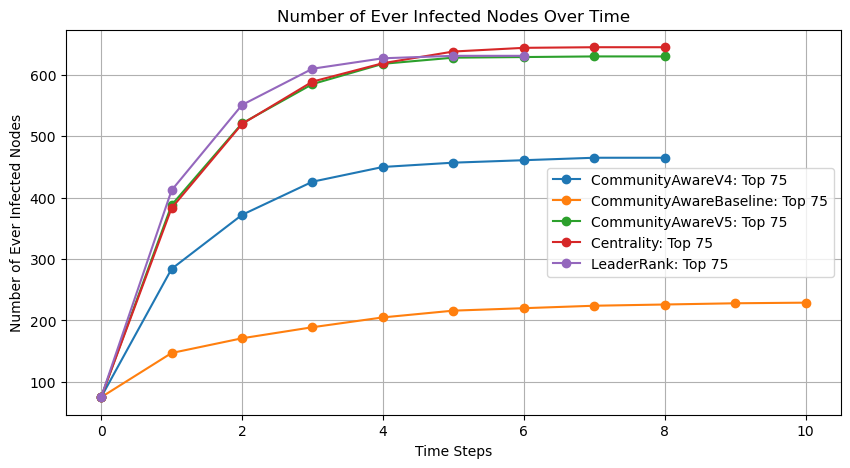

In [201]:

def plot_sir_simulation(G, sorted_maps, top, infection_prob=0.05, steps=100):
    plt.figure(figsize=(10, 5))

    # Calculate average in-degree
    avg_in_degree = sum(dict(G.in_degree()).values()) / G.number_of_nodes()
    print(avg_in_degree)
    recovery_prob = 1 / avg_in_degree

    # Iterate through all sorted maps
    for name, sorted_map in sorted_maps.items():
        top_nodes = [node for node, _ in sorted_map[:top]]  # Extract top nodes
        history, ever_infected, infected_counts = SIR_simulation(G, top_nodes, infection_prob, 1, steps)
        plt.plot(infected_counts, marker='o', linestyle='-', label=f'{name}: Top {top}')

    plt.title('Number of Ever Infected Nodes Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Ever Infected Nodes')
    plt.grid(True)
    plt.legend()
    plt.show()

def SIR_simulation(G, initial_infected, infection_prob=0.1, recovery_prob=0.05, steps=100):
    # Initialize the status of each node
    status = {node: 'S' for node in G.nodes()}
    for node in initial_infected:
        status[node] = 'I'

    history = []
    ever_infected = set(initial_infected)
    infected_counts = [len(ever_infected)]  # Initial number of infected nodes

    # Simulation process
    for _ in range(steps):
        new_status = status.copy()
        for node in G.nodes():
            if status[node] == 'I':
                # Determine neighbors based on whether the graph is directed
                if G.is_directed():
                    # For directed graphs, consider nodes that have edges towards 'node'
                    neighbors = [n for n in G.predecessors(node)]
                else:
                    # For undirected graphs, consider all neighbors
                    neighbors = list(G.neighbors(node))

                # Attempt to infect neighbors
                for neighbor in neighbors:
                    if status[neighbor] == 'S' and random.random() < infection_prob:
                        new_status[neighbor] = 'I'
                        ever_infected.add(neighbor)
                # Recovery process
                if random.random() < recovery_prob:
                    new_status[node] = 'R'
        history.append(new_status)
        status = new_status
        infected_counts.append(len(ever_infected))  # Record the total number of infected nodes

        if not any(s == 'I' for s in status.values()):
            break

    return history, ever_infected, infected_counts



sorted_maps = {
    "CommunityAwareV4": [(node, degree_centrality[node]) for node in ranked_nodes_ours],
   # "CommunityAwareOursInfomMap": [(node, degree_centrality[node]) for node in ranked_nodes_ours_infomap],
    "CommunityAwareBaseline": [(node, degree_centrality[node]) for node in ranked_nodes_Baseline],
    "CommunityAwareV5": [(node, degree_centrality[node]) for node in ranked_nodes_v5],
    "Centrality": sorted_centrality,
    #"PageRank": sorted_pagerank,
    "LeaderRank": sorted_leaderRank,
    #"H-index": sorted_hIndex,
    #"K-Shell": sorted_kShell
}


# 运行模拟并绘图
plot_sir_simulation(G, sorted_maps,top=75, infection_prob=0.007,steps=10)

In [29]:
# 使用Louvain算法进行社区检测
def detect_communities(G):
    partition = community_louvain.best_partition(G)
    return partition


# 统计前top节点在各社区中的分布
def count_top_nodes_in_communities(G, sorted_maps, top, partition):
    community_counts = {name: {} for name in sorted_maps.keys()}
    
    for name, sorted_map in sorted_maps.items():
        top_nodes = [node for node, _ in sorted_map[:top]]  # 提取前top个节点
        for node in top_nodes:
            community = partition[node]
            if community not in community_counts[name]:
                community_counts[name][community] = 0
            community_counts[name][community] += 1
    
    return community_counts

# 可视化前top节点在各社区中的分布
def plot_top_nodes_distribution(community_counts, top):
    plt.figure(figsize=(15, 10))

    for i, (name, counts) in enumerate(community_counts.items()):
        communities = list(counts.keys())
        counts = list(counts.values())
        
        plt.subplot(3, 3, i + 1)
        plt.bar(communities, counts)
        plt.title(f'Distribution of Top {top} Nodes in Communities\n({name})')
        plt.xlabel('Community')
        plt.ylabel('Number of Top Nodes')

    plt.tight_layout()
    plt.show()

# 统计每个社区的节点数量并排序
def count_and_sort_communities(partition):
    community_counts = {}
    for node, community in partition.items():
        if community not in community_counts:
            community_counts[community] = 0
        community_counts[community] += 1
    
    # 按照节点数量排序社区
    sorted_community_counts = sorted(community_counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_community_counts

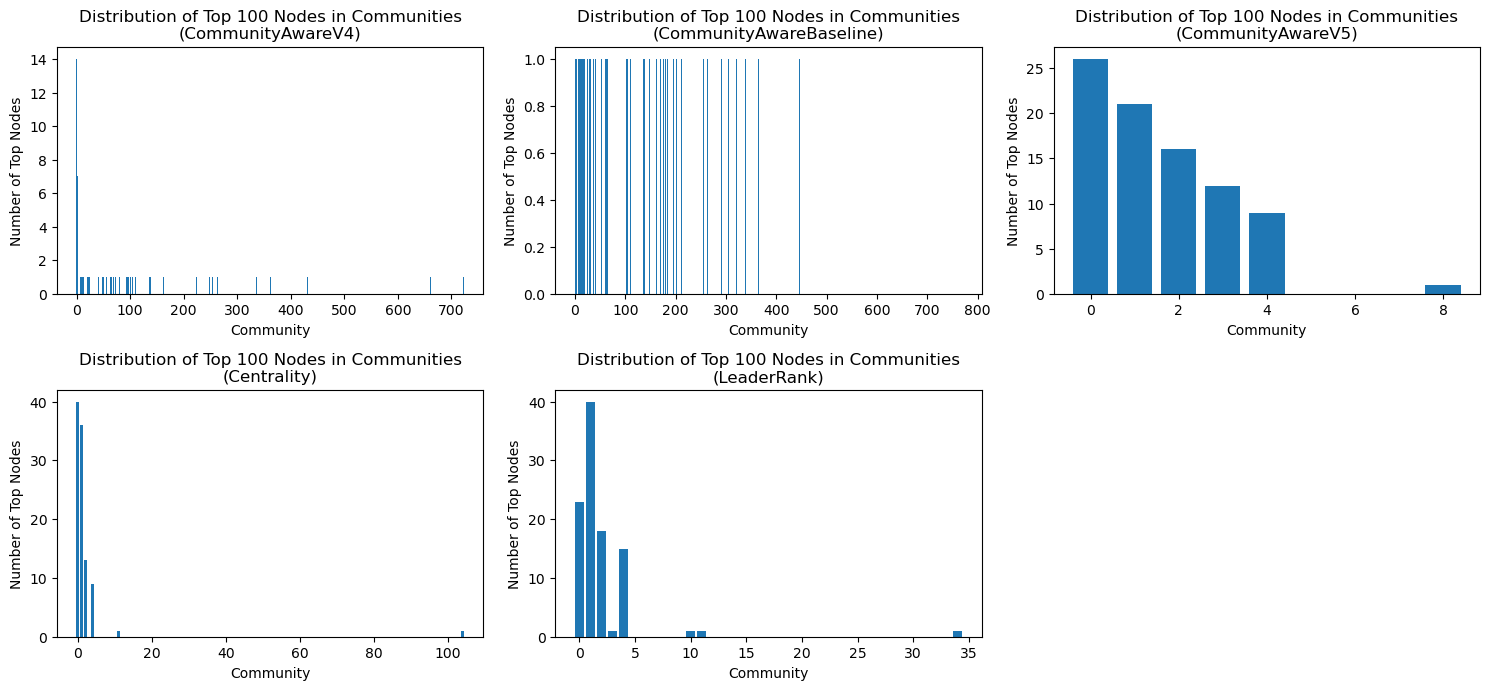

In [184]:

top = 100
community_counts = count_top_nodes_in_communities(G_edge, sorted_maps, top, partition)
plot_top_nodes_distribution(community_counts, top)

In [32]:

sorted_community_counts = count_and_sort_communities(partition)

for community, count in sorted_community_counts:
    print(f"Community {community}: {count} nodes")


Community 2: 16948 nodes
Community 0: 11957 nodes
Community 1: 11347 nodes
Community 4: 7803 nodes
Community 3: 6804 nodes
Community 11: 1894 nodes
Community 8: 1192 nodes
Community 10: 1116 nodes
Community 104: 918 nodes
Community 13: 887 nodes
Community 56: 850 nodes
Community 163: 833 nodes
Community 48: 805 nodes
Community 22: 629 nodes
Community 34: 588 nodes
Community 12: 496 nodes
Community 29: 473 nodes
Community 6: 428 nodes
Community 64: 420 nodes
Community 20: 404 nodes
Community 77: 394 nodes
Community 83: 389 nodes
Community 62: 350 nodes
Community 19: 328 nodes
Community 7: 311 nodes
Community 136: 280 nodes
Community 110: 268 nodes
Community 41: 256 nodes
Community 32: 255 nodes
Community 69: 228 nodes
Community 65: 217 nodes
Community 73: 209 nodes
Community 63: 188 nodes
Community 14: 161 nodes
Community 101: 137 nodes
Community 50: 110 nodes
Community 25: 65 nodes
Community 102: 63 nodes
Community 93: 46 nodes
Community 735: 45 nodes
Community 162: 40 nodes
Community 

In [58]:
def calculate_community_kshell_stats(partition, kshell_scores):
    """
    计算每个社区的k-shell值的均值和总值。

    参数:
    partition: 字典，节点到社区ID的映射。
    kshell_scores: 字典，节点的k-shell得分。

    返回:
    community_stats: 字典，每个社区的k-shell均值和总和。
    """
    # 组织每个社区的节点
    communities = {}
    for node, comm_id in partition.items():
        if comm_id not in communities:
            communities[comm_id] = []
        communities[comm_id].append(node)

    # 计算每个社区的k-shell均值和总和
    community_stats = {}
    for comm_id, nodes in communities.items():
        kshell_values = [kshell_scores[node] for node in nodes]
        mean_kshell = sum(kshell_values) / len(kshell_values) if kshell_values else 0
        total_kshell = sum(kshell_values)
        community_stats[comm_id] = {'mean': mean_kshell, 'total': total_kshell}

    return community_stats

community_stats = calculate_community_kshell_stats(partition, kShell)

# 打印每个社区的统计数据
for comm_id, stats in community_stats.items():
    print(f"社区 {comm_id} - 均值: {stats['mean']}, 总和: {stats['total']}")


社区 0 - 均值: 11.609266538429372, 总和: 138812
社区 1 - 均值: 9.724244293645897, 总和: 110341
社区 2 - 均值: 5.170698607505311, 总和: 87633
社区 3 - 均值: 9.515726043503822, 总和: 64745
社区 4 - 均值: 6.444957067794438, 总和: 50290
社区 104 - 均值: 4.442265795206971, 总和: 4078
社区 6 - 均值: 6.219626168224299, 总和: 2662
社区 7 - 均值: 3.327974276527331, 总和: 1035
社区 8 - 均值: 4.430369127516778, 总和: 5281
社区 9 - 均值: 4.8108108108108105, 总和: 178
社区 10 - 均值: 3.232078853046595, 总和: 3607
社区 11 - 均值: 2.6430834213305174, 总和: 5006
社区 12 - 均值: 7.63508064516129, 总和: 3787
社区 13 - 均值: 3.064261555806088, 总和: 2718
社区 14 - 均值: 5.316770186335404, 总和: 856
社区 15 - 均值: 2.142857142857143, 总和: 30
社区 34 - 均值: 3.1479591836734695, 总和: 1851
社区 17 - 均值: 1.875, 总和: 60
社区 77 - 均值: 3.5076142131979697, 总和: 1382
社区 19 - 均值: 5.2682926829268295, 总和: 1728
社区 20 - 均值: 2.376237623762376, 总和: 960
社区 22 - 均值: 3.2655007949125596, 总和: 2054
社区 23 - 均值: 1.5, 总和: 9
社区 24 - 均值: 6.818181818181818, 总和: 75
社区 25 - 均值: 2.4153846153846152, 总和: 157
社区 48 - 均值: 3.725465838509317, 总和

In [15]:
def read_directed_graph(file_path, skip_lines):
    G = nx.DiGraph()  # Initialize an empty directed graph
    with open(file_path, 'r') as file:
        for _ in range(skip_lines):
            next(file)  # Skip the initial descriptive lines
        for line in file:
            parts = line.strip().split()
            if len(parts) == 2:  # Only consider lines with exactly two node identifiers
                u, v = parts
                G.add_edge(u, v)
    
    return G


def leader_rank(G2, damping=0.85, tol=1e-6, max_iter=100):
    # Add the ground node connected to all other nodes
    ground_node = 'ground'
    G = G2.copy()
    G.add_node(ground_node)
    for node in G2.nodes():  # Connect the ground node to all other nodes
        G.add_edge(ground_node, node)
        G.add_edge(node, ground_node)  # Assuming undirected graph, add both directions

    # Create a mapping from node to index
    node_list = list(G.nodes())
    node_index = {node: i for i, node in enumerate(node_list)}
    n = len(node_list)
    
    # Initialize scores to 1 for all nodes
    scores = np.ones(n)
    
    # Create adjacency matrix
    row = []
    col = []
    data = []
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            degree = len(neighbors)
            for neighbor in neighbors:
                row.append(node_index[neighbor])
                col.append(node_index[node])
                data.append(1.0 / degree)
    
    adjacency_matrix = csr_matrix((data, (row, col)), shape=(n, n))
    
    # Power iteration: iterate until convergence
    for _ in range(max_iter):
        new_scores = adjacency_matrix.dot(scores)
        if np.linalg.norm(new_scores - scores, 1) < tol:
            break
        scores = new_scores
    
    # Remove the ground node score and normalize the scores
    scores = np.delete(scores, node_index[ground_node])
    total_score = np.sum(scores)
    scores /= total_score
    
    # Create the final scores dictionary
    final_scores = {node_list[i]: scores[i] for i in range(n) if node_list[i] != ground_node}
    
    return final_scores





def calculate_h_index(G):
    h_index = {}
    for node in G.nodes():
        degrees = [G.degree(neighbor) for neighbor in G.neighbors(node)]
        degrees.sort(reverse=True)
        h = 0
        for i, degree in enumerate(degrees):
            if degree >= i + 1:
                h = i + 1
            else:
                break
        h_index[node] = h
    return h_index


In [ ]:
# Initialize an empty directed graph
# Load the .mtx file
wiki_path = '/Users/qing/Desktop/24s1/comp8880/project/code/data/wiki-Vote.txt'
G_wiki = read_directed_graph(wiki_path,4)
# Calculate number of nodes and edges in the graph
num_nodes = G_wiki.number_of_nodes()
num_edges = G_wiki.number_of_edges()

num_nodes, num_edges

centrality = nx.degree_centrality(G_wiki)
betweenness_manual = nx.betweenness_centrality(G_wiki)
closeness_manual = nx.closeness_centrality(G_wiki)
pagerank = nx.pagerank(G_wiki, alpha=0.85, personalization=None)
leaderRank = leader_rank(G_wiki)
hIndex = calculate_h_index(G_wiki)
kShell = nx.core_number(G_wiki)

sorted_centrality = sorted(centrality.items(), key=lambda item: item[1], reverse=True)
sorted_betweenness = sorted(betweenness_manual.items(), key=lambda item: item[1], reverse=True)
sorted_closeness = sorted(closeness_manual.items(), key=lambda item: item[1], reverse=True)
sorted_pagerank =  sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
sorted_leaderRank =  sorted(leaderRank.items(), key=lambda item: item[1], reverse=True)
sorted_hIndex =  sorted(hIndex.items(), key=lambda item: item[1], reverse=True)
sorted_kShell=  sorted(kShell.items(), key=lambda item: item[1], reverse=True)


print(sorted_centrality[:3])
print(sorted_betweenness[:3])
print(sorted_closeness[:3])
print(sorted_pagerank[:3])
print(sorted_leaderRank[:3])
print(sorted_hIndex[:3])
print(sorted_kShell[:3])



# 假设 sorted_centrality, sorted_betweenness 等都是已经计算好并排序的元组列表
data_to_save = {
    "Centrality": sorted_centrality,
    "Betweenness": sorted_betweenness,
    "Closeness": sorted_closeness,
    "PageRank": sorted_pagerank,
    "LeaderRank": sorted_leaderRank,
    "HIndex": sorted_hIndex,
    "KShell": sorted_kShell
}

with open('saved/network_metrics_wiki.json', 'w') as f:
    json.dump(data_to_save, f, indent=4)
